In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

#Datasets without outlier handling
data_path = r"/content/drive/MyDrive/my Time Series/Final_1h_Feature Engineering_No Missing.csv"
#data_path = r"/content/drive/MyDrive/my Time Series/CFS_based_feature.csv"
#data_path = r"/content/drive/MyDrive/my Time Series/Rank_based_feature.csv"

#Datasets with outlier handling
#data_path = r"/content/drive/MyDrive/my Time Series/Clipped_all_features.csv"
#data_path = r"/content/drive/MyDrive/my Time Series/Clipped_CFS.csv"
#data_path = r"/content/drive/MyDrive/my Time Series/Clipped_Rank.csv"


def load_data(path=data_path):
    df = pd.read_csv(path)
    df = df.drop(columns=['timestamp'])  # remove timestamp
    X = df.drop(columns=['cooling_power'])  # independent variables
    Y = df[['cooling_power']]  # target variable
    return X, Y


df = load_data()

In [ ]:
X, Y = load_data()

def split_data(X, Y, train_fraq):

    """Splits input X and target Y into train, val, and test sets."""
    test_slice = int(len(X) * 0.85)
    X_test, Y_test = X[test_slice:], Y[test_slice:]
    X_train_val, Y_train_val = X[:test_slice], Y[:test_slice]

    train_size = int(len(X) * 0.7)

    X_train, Y_train = X_train_val[:train_size], Y_train_val[:train_size]
    X_val, Y_val = X_train_val[train_size:], Y_train_val[train_size:]

    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)


train_multi, val_multi, test_multi = split_data(X, Y, train_fraq=0.8)

print("Multivariate Datasets")
print(f"Train Data Shape: {train_multi[0].shape}") # Access the shape of X_train
print(f"Val Data Shape: {val_multi[0].shape}")   # Access the shape of X_val
print(f"Test Data Shape: {test_multi[0].shape}")  # Access the shape of X_test
print(f"Nulls In Train {np.any(np.isnan(train_multi[0]))}") # Access X_train for null check
print(f"Nulls In Validation {np.any(np.isnan(val_multi[0]))}") # Access X_val for null check
print(f"Nulls In Test {np.any(np.isnan(test_multi[0]))}") # Access X_test for null check

Multivariate Datasets
Train Data Shape: (3040, 13)
Val Data Shape: (652, 13)
Test Data Shape: (652, 13)
Nulls In Train False
Nulls In Validation False
Nulls In Test False


In [ ]:
train_multi, val_multi, test_multi = split_data(X, Y, train_fraq=0.8, test_len=108)
train_X, train_Y = train_multi
val_X, val_Y = val_multi
test_X, test_Y = test_multi
print(train_X.shape, train_Y.shape, val_X.shape, val_Y.shape, test_X.shape, test_Y.shape)

(3040, 13) (3040, 1) (652, 13) (652, 1) (652, 13) (652, 1)


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

regressor = XGBRegressor(
    objective="reg:squarederror",  # Default for regression tasks
    n_estimators=300,              # Number of trees (default: 100)
    learning_rate=0.3,             # Step size shrinkage (default: 0.3)
    max_depth=2,                   # Maximum depth of trees (default: 6)
    min_child_weight=1,            # Minimum sum of instance weight needed in a child (default: 1)
    gamma=0,                       # Minimum loss reduction for a split (default: 0)
    subsample=0.8,                 # Fraction of samples used for training (default: 1.0)
    colsample_bytree=0.8,          # Fraction of features used per tree (default: 1.0)
    reg_alpha=0.8,                  # L1 regularization (default: 0)
    reg_lambda=10,                 # L2 regularization (default: 1)
    random_state= 15,              # Seed for reproducibility
    verbosity=1                    # Verbosity level (0 = silent, 1 = warnings, 2 = info)
)


regressor.fit(train_X, train_Y)
y_val_pred = regressor.predict(val_X)
y_pred = regressor.predict(test_X)



# Evaluate the model
mae_val = mean_absolute_error(val_Y, y_val_pred)
mse_val = mean_squared_error(val_Y, y_val_pred)
rmse_val = np.sqrt(mse_val)
mape_val = float(mean_absolute_percentage_error(val_Y, y_val_pred)*100)

print("Val Mean Squared Error (MSE):", mse_val)
print("Val Mean Aquared Error (MAE):", mae_val)
print("Val Root Mean Squared Error (RMSE):", rmse_val)
print("Val Mean Absolute Percentage Error (MAPE):", mape_val, "%")

mae = mean_absolute_error(test_Y, y_pred)
mse = mean_squared_error(test_Y, y_pred)
rmse = np.sqrt(mse)
mape = float(mean_absolute_percentage_error(test_Y, y_pred)*100)
print("##############")
print("Test Mean Squared Error (MSE):", mse)
print("Test Mean Absolute Error (MAE):", mae)
print("Test Root Mean Squared Error (RMSE):", rmse)
print("Test Mean Absolute Percentage Error (MAPE):", mape, "%")



Val Mean Squared Error (MSE): 2.8105314495585128
Val Mean Aquared Error (MAE): 1.3094025744614863
Val Root Mean Squared Error (RMSE): 1.6764639720430954
Val Mean Absolute Percentage Error (MAPE): 10.143098455283916 %
##############
Test Mean Squared Error (MSE): 3.1937151672965762
Test Mean Absolute Error (MAE): 1.487695109209868
Test Root Mean Squared Error (RMSE): 1.7870968544811936
Test Mean Absolute Percentage Error (MAPE): 12.554292961915634 %


<Figure size 15000x9000 with 0 Axes>

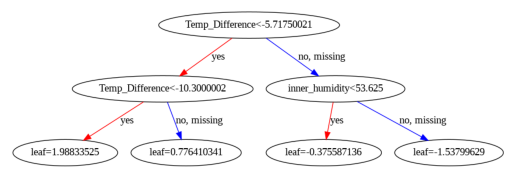

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(150, 90))
plot_tree(regressor, num_trees=0)
plt.show()

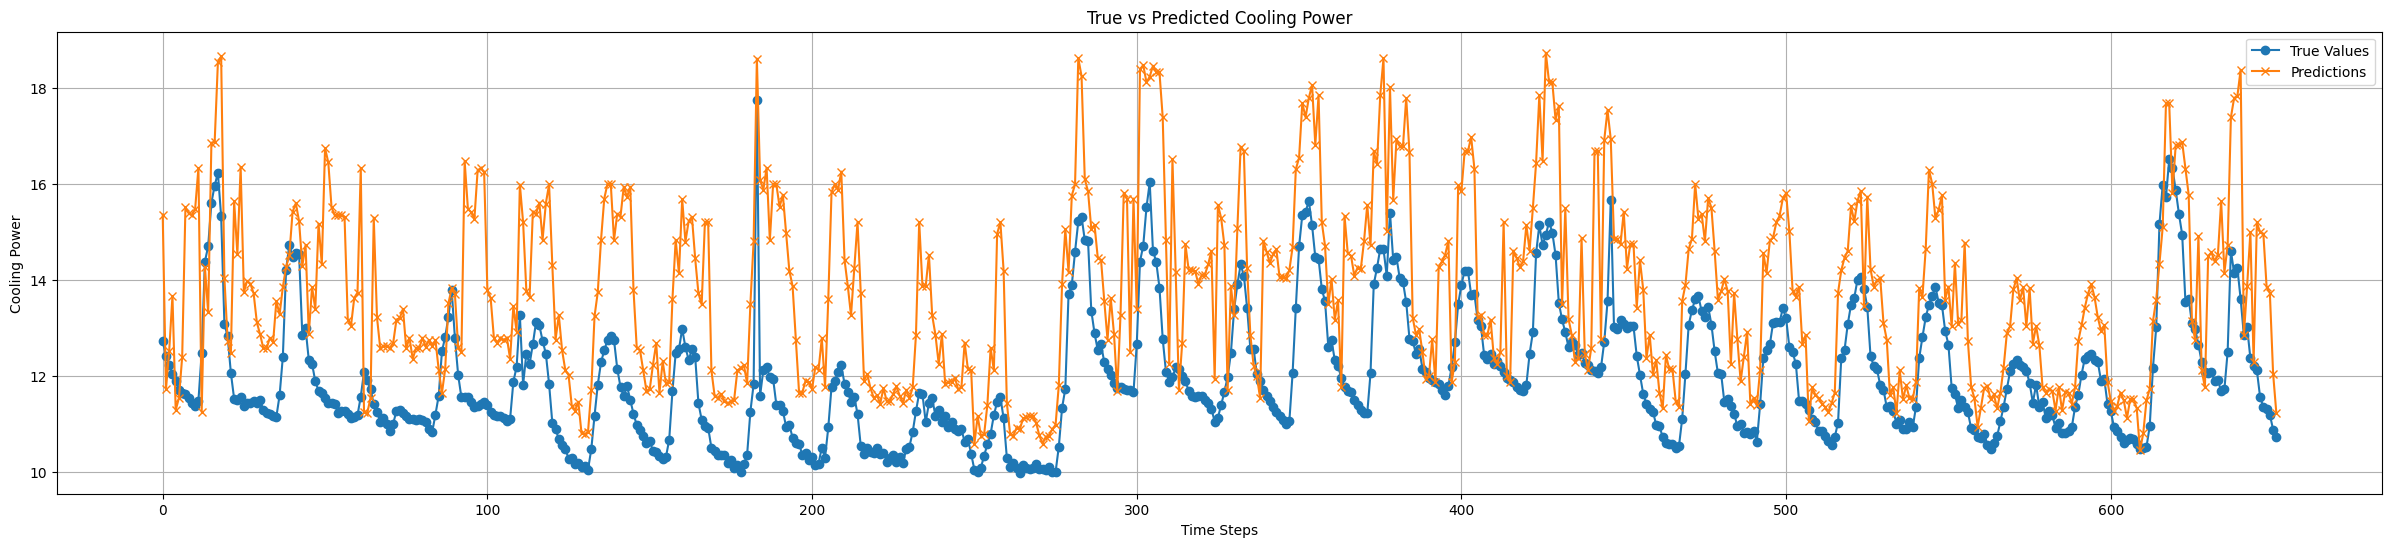

In [ ]:

import matplotlib.pyplot as plt

# 샘플 수 선택 (테스트 데이터 일부만 시각화)
sample_size = len(test_Y)
#sample_size = 100

test_Y_1=test_Y.reset_index()
test_Y_1=test_Y_1.drop(columns=['index'])
#sample_size = 100
plt.figure(figsize=(30, 6))

plt.plot(test_Y_1[:sample_size], label="True Values", marker='o')
plt.plot(y_pred[:sample_size], label="Predictions", marker='x')

plt.title("True vs Predicted Cooling Power")
plt.xlabel("Time Steps")
plt.ylabel("Cooling Power")
plt.legend()
plt.grid()
plt.show()


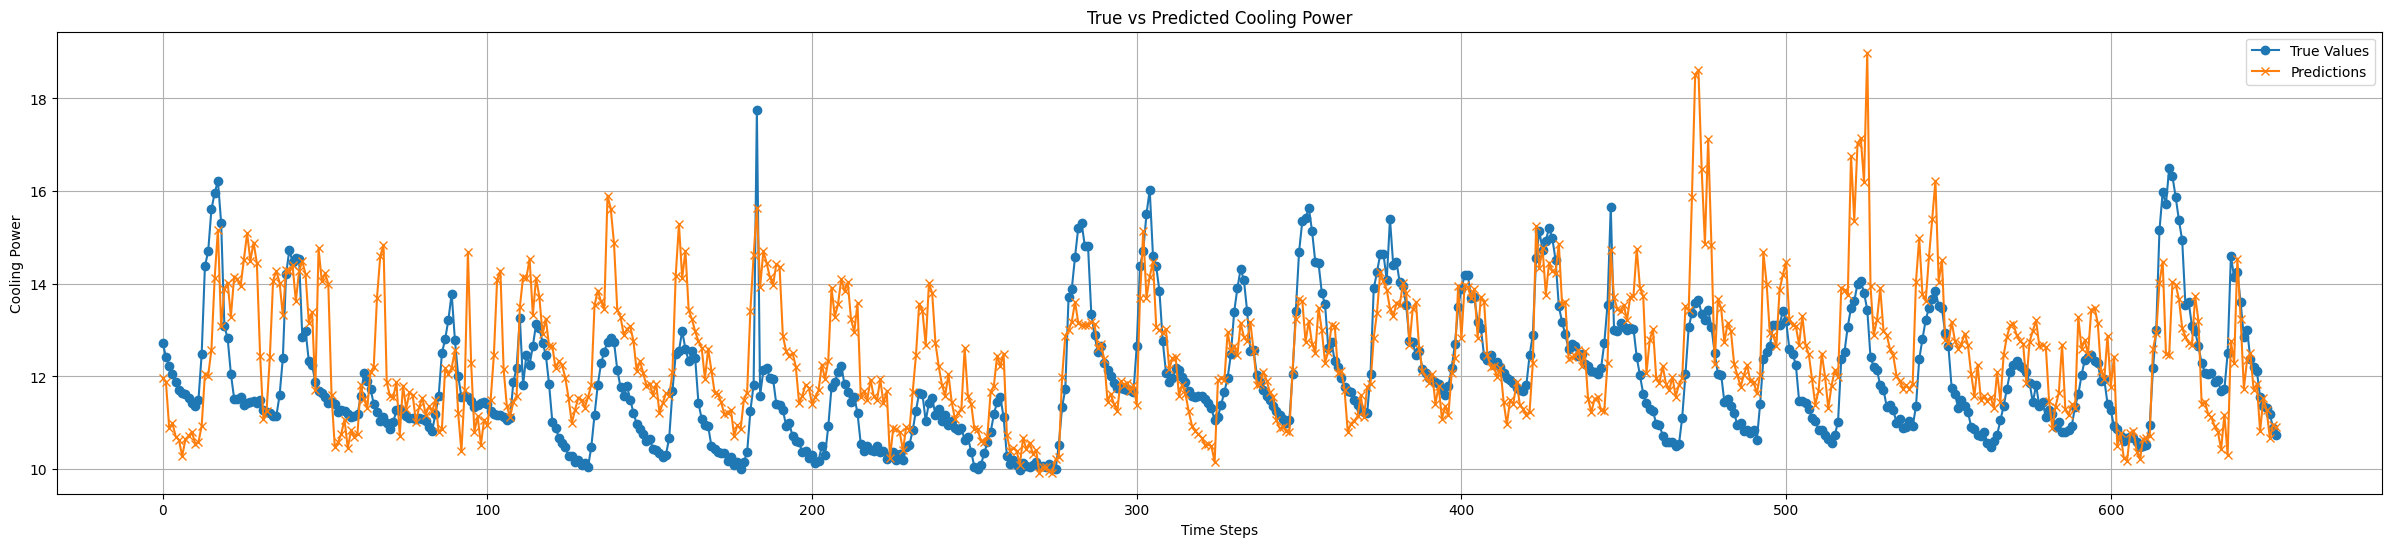

In [ ]:
import matplotlib.pyplot as plt

#Trial with other hyperparameters

# 샘플 수 선택 (테스트 데이터 일부만 시각화)
sample_size = len(test_Y)
#sample_size = 100

test_Y_1=test_Y.reset_index()
test_Y_1=test_Y_1.drop(columns=['index'])
#sample_size = 100
plt.figure(figsize=(30, 6))

plt.plot(test_Y_1[:sample_size], label="True Values", marker='o')
plt.plot(y_pred[:sample_size], label="Predictions", marker='x')

plt.title("True vs Predicted Cooling Power")
plt.xlabel("Time Steps")
plt.ylabel("Cooling Power")
plt.legend()
plt.grid()
plt.show()


# **Getting Best Parameters**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer # Import make_scorer

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinking
    #'max_depth': [3, 5, 7, 10],  # Maximum depth of a tree
    #'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian) in a child
    #'subsample': [0.7, 0.8, 1.0],  # Fraction of samples to be used for each tree
    #'colsample_bytree': [0.7, 0.8, 1.0],  # Fraction of features to be used per tree
    #'#colsample_bylevel': [0.7, 0.8, 1.0],  # Fraction of features to be used at each level
    #'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a further partition
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2],  # L2 regularization term on weights
    #'random_state':[1,12,15,16]
    #'scale_pos_weight': [1, 2, 5],  # Control the balance of positive and negative weights
    #'objective': ['reg:squarederror', 'reg:gamma', 'reg:tweedie'],  # Objective function
    #'booster': ['gbtree', 'gblinear', 'dart'],  # Type of boosting model
    #'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],  # Tree construction algorithm
    #'eval_metric': ['rmse', 'mae', 'logloss'],  # Evaluation metric
    #'max_delta_step': [0, 1, 5]  # Maximum step size at each tree's update
}

neg_mean_absolute_percentage_error = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(regressor, param_grid, n_iter=100, cv=5, n_jobs=-1, scoring= neg_mean_absolute_percentage_error, random_state=42)
random_search.fit(train_X, train_Y)

# Get the best parameters
best_params_random = random_search.best_params_
print("Best Parameters from Randomized Search:", best_params_random)

# Get the best model
best_regressor_random = random_search.best_estimator_

# Predict on validation set and test set
y_val_pred_random = best_regressor_random.predict(val_X)
y_pred = best_regressor_random.predict(test_X)

# Evaluate the model
mae_val_random = mean_absolute_error(val_Y, y_val_pred_random)
mse_val_random = mean_squared_error(val_Y, y_val_pred_random)
rmse_val_random = np.sqrt(mse_val_random)
mape_val_random = mean_absolute_percentage_error(val_Y, y_val_pred_random)

# Print evaluation metrics
print("Val Mean Squared Error (MSE) - Randomized Search:", mse_val_random)
print("Val Mean Absolute Error (MAE) - Randomized Search:", mae_val_random)
print("Val Root Mean Squared Error (RMSE) - Randomized Search:", rmse_val_random)
print("Val Mean Absolute Percentage Error (MAPE) - Randomized Search:", mape_val_random)

# Evaluate on test set
#mse_test_random = mean_squared_error(test_Y, y_pred_random)
#print("Test Mean Squared Error (MSE) - Randomized Search:", mse_test_random)



mae = mean_absolute_error(test_Y, y_pred)
mse = mean_squared_error(test_Y, y_pred)
rmse = np.sqrt(mse)
mape = float(mean_absolute_percentage_error(test_Y, y_pred)*100)
print("##############")
print("Test Mean Squared Error (MSE):", mse)
print("Test Mean Absolute Error (MAE):", mae)
print("Test Root Mean Squared Error (RMSE):", rmse)
print("Test Mean Absolute Percentage Error (MAPE):", mape, "%")
"""
#for all dataset
Best Parameters from Randomized Search: {'tree_method': 'hist', 'subsample': 0.7, 'scale_pos_weight': 2, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'max_delta_step': 1, 'learning_rate': 0.2, 'gamma': 0.3, 'eval_metric': 'logloss', 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'booster': 'gblinear'}
Val Mean Squared Error (MSE) - Randomized Search: 4.3394269988897225
Val Mean Absolute Error (MAE) - Randomized Search: 1.705515445691442
Val Root Mean Squared Error (RMSE) - Randomized Search: 2.083129136393066
Val Mean Absolute Percentage Error (MAPE) - Randomized Search: 0.133647874250679
Test Mean Squared Error (MSE) - Randomized Search: 4.878851586325408
"""



Best Parameters from Randomized Search: {'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 100, 'learning_rate': 0.05}
Val Mean Squared Error (MSE) - Randomized Search: 4.6417844200375775
Val Mean Absolute Error (MAE) - Randomized Search: 1.7679049941932352
Val Root Mean Squared Error (RMSE) - Randomized Search: 2.154480081141986
Val Mean Absolute Percentage Error (MAPE) - Randomized Search: 0.13951513507999885
##############
Test Mean Squared Error (MSE): 3.820752716741546
Test Mean Absolute Error (MAE): 1.7356411587800573
Test Root Mean Squared Error (RMSE): 1.9546745807784849
Test Mean Absolute Percentage Error (MAPE): 14.667967290512465 %


"\n#for all dataset\nBest Parameters from Randomized Search: {'tree_method': 'hist', 'subsample': 0.7, 'scale_pos_weight': 2, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'max_delta_step': 1, 'learning_rate': 0.2, 'gamma': 0.3, 'eval_metric': 'logloss', 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'booster': 'gblinear'}\nVal Mean Squared Error (MSE) - Randomized Search: 4.3394269988897225\nVal Mean Absolute Error (MAE) - Randomized Search: 1.705515445691442\nVal Root Mean Squared Error (RMSE) - Randomized Search: 2.083129136393066\nVal Mean Absolute Percentage Error (MAPE) - Randomized Search: 0.133647874250679\nTest Mean Squared Error (MSE) - Randomized Search: 4.878851586325408\n"

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Define the hyperparameters to tune

param_grid = {
    'n_estimators': [100, 200, 300],                                 # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],                          # Step size shrinking
    'max_depth': [3, 5, 7, 10],                                      # Maximum depth of a tree
    'min_child_weight': [1, 3, 5],                                   # Minimum sum of instance weight (hessian) in a child
    'subsample': [0.7, 0.8, 1.0],                                    # Fraction of samples to be used for each tree
    'colsample_bytree': [0.7, 0.8, 1.0],                              # Fraction of features to be used per tree
    'colsample_bylevel': [0.7, 0.8, 1.0],                             # Fraction of features to be used at each level
    'gamma': [0, 0.1, 0.2, 0.3],                                      # Minimum loss reduction required to make a further partition
    'reg_alpha': [0, 0.1, 0.5, 1],                                    # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2],                                        # L2 regularization term on weights
    'objective': ['reg:squarederror', 'reg:gamma', 'reg:tweedie'],  # Objective function
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(regressor, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(train_X, train_Y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)ㄴ

# Get the best model
best_regressor = grid_search.best_estimator_

# Predict on validation set and test set
y_val_pred = best_regressor.predict(val_X)
y_pred = best_regressor.predict(test_X)

# Evaluate the model
mae_val = mean_absolute_error(val_Y, y_val_pred)
mse_val = mean_squared_error(val_Y, y_val_pred)
rmse_val = np.sqrt(mse_val)
mape_val = mean_absolute_percentage_error(val_Y, y_val_pred)

# Print evaluation metrics
print("Val Mean Squared Error (MSE):", mse_val)
print("Val Mean Absolute Error (MAE):", mae_val)
print("Val Root Mean Squared Error (RMSE):", rmse_val)
print("Val Mean Absolute Percentage Error (MAPE):", mape_val)

# Evaluate on test set
mse_test = mean_squared_error(test_Y, y_pred)
print("Test Mean Squared Error (MSE):", mse_test)


Best Parameters: {'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1.5}
Val Mean Squared Error (MSE): 2.860099739712498
Val Mean Absolute Error (MAE): 1.3242433502978928
Val Root Mean Squared Error (RMSE): 1.6911829409358698
Val Mean Absolute Percentage Error (MAPE): 0.10296508525592808
Test Mean Squared Error (MSE): 7.3632741325637445


# **Feature Importance**


Feature Importances:
               Feature  Importance
1      Temp_Difference    0.444219
0    inner_temperature    0.239601
2       inner_humidity    0.189954
3  Humidity_Difference    0.083667
4  outside_temperature    0.042560


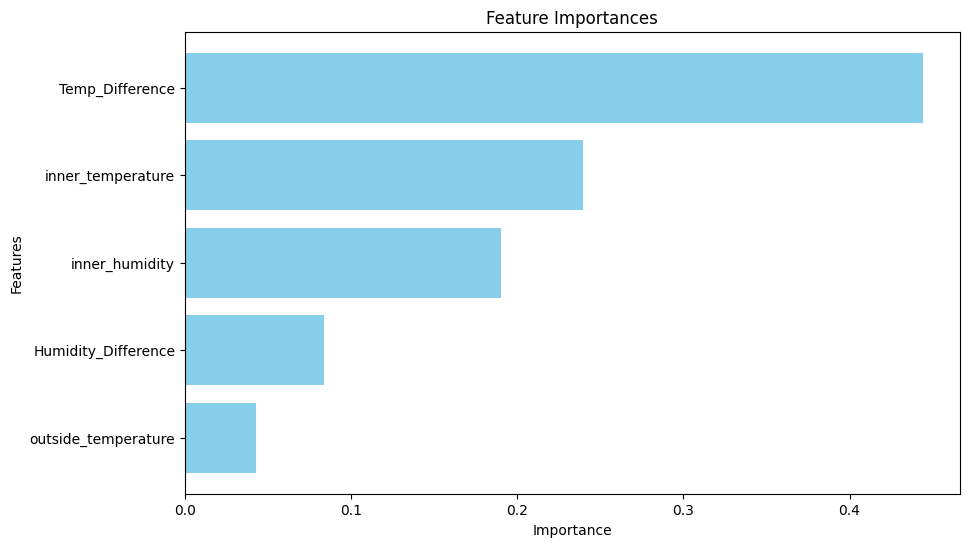

In [ ]:
#Feature importance with the new code
X, Y = load_data()

import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Extract feature importances
feature_importances = regressor.feature_importances_
feature_names = X.columns

# Display feature importance in descending order
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

# Plot feature importance (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()